In [1]:
from  AISecClient import AISecClient
import os
from transformers import AutoImageProcessor, ResNetForImageClassification
from time import sleep
from datasets import load_dataset
import torch
from datetime import datetime
from art.estimators.classification import BlackBoxClassifier, KerasClassifier
from art.attacks.evasion import HopSkipJump
from art.attacks.extraction import CopycatCNN
from art.utils import to_categorical
import numpy as np
from matplotlib import pyplot as plt

C:\Users\admin1\anaconda3\envs\hiddenlayer\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# setup session to use for demo
# ADD CLIENT ID AND CLIENT SECRET TO RUN NOTEBOOK
client_id = os.getenv('HIDDENLAYER_CLIENT_ID')
client_secret = os.getenv('HIDDENLAYER_CLIENT_SECRET')
client = AISecClient(client_id, client_secret)

In [4]:
# load dataset
dataset = load_dataset("zh-plus/tiny-imagenet")
# load the microsoft/resnet-50 model
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
sensor = client.get_sensor_by_name_version("microsoft/resnet-50", 1)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to C:/Users/admin1/.cache/huggingface/datasets/zh-plus___parquet/Maysee--tiny-imagenet-2eb6c3acd8ebc62a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
len(dataset['valid']['image'])

In [ ]:
for img in dataset["valid"]["image"][1000:1010]:
    display(img)

In [ ]:

# iterate over a subset of the dataset and classify images using resnet-50
with torch.no_grad():
    for img in dataset["valid"]["image"][1001:1002]:
        pimg = processor(img, return_tensors="pt")
        predictions = model(pimg["pixel_values"])
        label = predictions.logits.argmax(-1).item()
        text_label = model.config.id2label[label]
        #client.submit_to_mldr(sensor["sensor_id"], "resnet-50-demo", pimg["pixel_values"].numpy(), predictions.logits.numpy(), predictions=[label])
        display(img)
        print(f"Label: {text_label}")


## 7a. View model inferences in console

In the console, all inferences can be viewed here at https://console.hiddenlayer.ai/inferences. Details of each inference can also be viewed. Inferences for a specific model can be viewed by navigating to the model card then choosing the Inferences tab. 


In [16]:
sensor = client.get_sensor_by_name_version('nateraw/vit-age-classifier', 1)  

In [5]:

# create a custom predict method to use for the attack
sensor = client.get_sensor_by_name_version("microsoft/resnet-50", 1)
#sensor = client.get_sensor_by_name_version('nateraw/vit-age-classifier', 1)
#sensor = client.get_sensor_by_name_version('facebook/convnext-base-224', 1)
#sensor = client.get_sensor_by_name_version('Apple/AIM-1B', 1)  
sensor_id = sensor["sensor_id"]

def predict(inputs):
    probs = []
    for i in inputs:
        a = np.array([i])
        t = torch.from_numpy(a)
        p = model(t)
        l = p.logits.argmax(-1).item()
        o = p.logits.detach().numpy()
        probs.append(o[0])
        with open('count.txt', 'a') as f:
            f.write(str(datetime.now()) + '\n' )
        client.submit_to_mldr(sensor_id, "resnet-50-demo-attack", a, o, predictions=[l])
    return probs



# Run a HopJumpSkip attack against microsoft/resnet-50 using ART
In this step, we will run a hopskipjump attack against the resnet-50 model. This attack is used to generate adversarial samples against the model that can be used to evade a certain classificaiton or even create a sample to get a specific classification.


## Show starting image and current label

Base image...


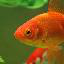

Label: goldfish, Carassius auratus
----------------------------------


In [6]:
# show starting image and current label
image = dataset["valid"]["image"][3]
pimg = processor(image, return_tensors="pt")
predictions = model(pimg["pixel_values"])
pimg_arr = pimg["pixel_values"].detach().numpy()
label = predictions.logits.argmax(-1).item()
text_label = model.config.id2label[label]
print("Base image...")
display(image)
print(f"Label: {text_label}")
print("----------------------------------")

In [7]:
# create attack classifier
attack_classifier = BlackBoxClassifier(predict_fn=predict, nb_classes=1000, input_shape=list(pimg_arr[0].shape))

# create attack object with params for the attack
hopskipjump_attack = HopSkipJump(classifier=attack_classifier,
                                 max_iter=0, 
                                 max_eval=10, 
                                 init_eval=1, 
                                 targeted=False,
                                norm = np.inf)

## Starting attack...

Starting attack...


HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 224, 224)
torch.Size([1, 3, 224, 224])


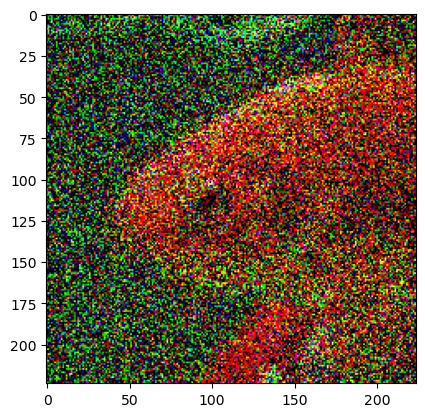

Class label: 107, jellyfish
Attack complete


In [8]:
print("Starting attack...")
iter_step = 10
for i in range(1):
    x_adv = hopskipjump_attack.generate(x=pimg_arr, resume=True)
    print (x_adv.shape)
    t = torch.from_numpy(x_adv)
    print (t.shape)
    p = model(t)
    l = p.logits.argmax(-1).item()
    tl = model.config.id2label[l]
    
    plt.imshow(t[0].squeeze().permute(1,2,0))
    plt.show(block=False)
    print(f"Class label: {l}, {tl}")
    hopskipjump_attack.max_iter = iter_step
print("Attack complete")


## View detections in console

All detections can be viewed here at https://console.hiddenlayer.ai/inference-detections?activeTab=detections. The overview provides a list of each detection and the [dashboard](https://console.hiddenlayer.ai/inference-detections?activeTab=dashboard) is an aggregated view of the detections. Detections for a specific model can be viewed by navigating to the model card then choosing the Detections tab. 


In [ ]:
plt.imshow(x_adv[0].transpose(1,2,0))
plt.show(block=False)

In [ ]:
Total Inferences 4159; Severity 1819
Total Inferences 4174; Severity 1828
Total Inferences 4581; Severity 2175
Total Inferences 5155; Severity 2582

In [ ]:
4174 - 4159

In [ ]:
copycatcnn_attack = CopycatCNN(classifier=attack_classifier)

In [ ]:
target_classifier = KerasClassifier(model=model)

In [ ]:
print("Starting attack...")
iter_step = 10
for i in range(1):
    x_adv = copycatcnn_attack.extract(x=pimg_arr, thieved_classifier = attack_classifier)
    t = torch.from_numpy(x_adv)
    p = model(t)
    l = p.logits.argmax(-1).item()
    tl = model.config.id2label[l]
    
    plt.imshow(t[0].squeeze().permute(1,2,0))
    plt.show(block=False)
    print(f"Class label: {l}, {tl}")
    hopskipjump_attack.max_iter = iter_step
print("Attack complete")


In [ ]:
209